In [5]:
import itk
import vtk
from vtk import vtkCommand
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

IF3         = itk.Image[itk.F, 3]
IUC3        = itk.Image[itk.UC, 3]
IRGBUC3     = itk.Image[itk.RGBPixel[itk.UC], 3]
LMLOUL3     = itk.LabelMap[itk.StatisticsLabelObject[itk.UL, 3]]

class SliceViewInteractorStyle(vtk.vtkInteractorStyleUser):
    def __init__(self, parent=None, imageViewer=None):
        self.AddObserver(vtkCommand.MouseWheelForwardEvent, self.mouseWheelForwardEvent)        
        self.AddObserver(vtkCommand.MouseWheelBackwardEvent, self.mouseWheelBackwardEvent)
        if imageViewer:
            self.imageViewer = imageViewer
            self.minSlice = imageViewer.GetSliceMin()
            self.maxSlice = imageViewer.GetSliceMax()
            self.slice = round((self.minSlice + self.maxSlice) / 2)
            print(self.minSlice, self.maxSlice)
        
    def nextSlice(self):
        if self.imageViewer and self.slice < self.maxSlice:
            self.slice = self.slice + 1
            self.imageViewer.SetSlice(self.slice)
            self.imageViewer.GetRenderer().Render()

    def previousSlice(self):
        if self.imageViewer and self.slice > self.minSlice:
            self.slice = self.slice - 1
            self.imageViewer.SetSlice(self.slice)
            self.imageViewer.GetRenderer().Render()
    
    def mouseWheelForwardEvent(self, obj, event):
        self.nextSlice()
        return
    
    def mouseWheelBackwardEvent(self, obj, event):
        self.previousSlice()
        return

class DicomSeries():
  
  def __init__(self, fileNames):
    self.fileNames = fileNames
    self.type = IUC3
    self.generatePipeline(fileNames)

  def generatePipeline(self, fileNames):
    # itk.ImageFileReader -> itk.ImageSeriesReader -> 
    # RescaleIntensityImageFilter -> CastImageFilter -> 
    # itk.ImageToVTKImageFilter -> vtkImageViewer2
    imageSeriesReader = itk.ImageSeriesReader[IF3].New()
    imageSeriesReader.SetFileNames(fileNames)
    imageSeriesReader.Update()
    rescaler = itk.RescaleIntensityImageFilter[IF3, IF3].New()
    rescaler.SetInput(imageSeriesReader.GetOutput())
    rescaler.SetOutputMaximum(255)
    rescaler.SetOutputMinimum(0)
    rescaler.Update()
    self.caster = itk.CastImageFilter[IF3, IUC3].New()
    self.caster.SetInput(rescaler.GetOutput())
    self.caster.Update()

  def GetOutput(self):
    return self.caster.GetOutput()

class LabelMap():
  
  def __init__(self, referenceImage, niiPath=None, numpyLabelMap=None):
    self.niiPath = niiPath
    self.numpyLabelMap = numpyLabelMap
    self.type = IUC3
    self.referenceImage = referenceImage
    if niiPath:
      self.generatePipeline(referenceImage, niiPath=niiPath)
    elif numpyLabelMap:
      self.generatePipeline(referenceImage, numpyLabelMap=numpyLabelMap)

  def generatePipeline(self, referenceImage, niiPath=None, numpyLabelMap=None):
    if niiPath:
      # itk.ResampleImageFilter -> itk.LabelImageToLabelMapFilter -> itk.LabelMapOverlayImageFilter
      niiReader = itk.ImageFileReader[IUC3].New()
      niiReader.SetFileName(niiPath)
      niiReader.Update()

      multFilter = itk.MultiplyImageFilter[IUC3, IUC3, IUC3].New()
      multFilter.SetInput(niiReader.GetOutput())
      multFilter.SetConstant(100)

        
      self.resampleImageFilter = itk.ResampleImageFilter[IUC3, IUC3].New()
      self.resampleImageFilter.SetInput(multFilter.GetOutput())
      self.resampleImageFilter.SetTransform(itk.IdentityTransform[itk.D, 3].New())
      self.resampleImageFilter.SetInterpolator(itk.NearestNeighborInterpolateImageFunction[IUC3, itk.D].New())
      self.resampleImageFilter.UseReferenceImageOn()
      self.resampleImageFilter.SetReferenceImage(referenceImage)
      self.resampleImageFilter.Update()

    elif numpyLabelMap:
      # Itk.changeInformationImageFilter -> itk.ResampleImageFilter -> itk.LabelImageToLabelMapFilter -> itk.LabelMapOverlayImageFilter
      changeInformationImageFilter = itk.ChangeInformationImageFilter[IUC3].New()
      changeInformationImageFilter.SetInput(numpyLabelMap)
      changeInformationImageFilter.UseReferenceImageOn()
      changeInformationImageFilter.ChangeDirectionOn()
      changeInformationImageFilter.ChangeSpacingOn()
      changeInformationImageFilter.ChangeOriginOn()
      changeInformationImageFilter.SetReferenceImage(caster.GetOutput())
      self.resampleImageFilter = itk.ResampleImageFilter[IUC3, IUC3].New()
      self.resampleImageFilter.SetInput(changeInformationImageFilter.GetOutput())
      self.resampleImageFilter.SetTransform(itk.IdentityTransform[itk.D, 3].New())
      self.resampleImageFilter.SetInterpolator(itk.NearestNeighborInterpolateImageFunction[IUC3, itk.D].New())
      self.resampleImageFilter.UseReferenceImageOn()
      self.resampleImageFilter.SetReferenceImage(referenceImage)

  def GetOutput(self):
    return self.resampleImageFilter.GetOutput()

In [6]:
NII_PATH = "/Users/benjaminhon/Developer/HeadHunter/notebooks/220259.nii"
DICOM_PATH = "/Users/benjaminhon/Developer/HeadHunter/notebooks/220259"

def generateSeries(path):
    generator = itk.GDCMSeriesFileNames.New()
    generator.SetDirectory(path)
    seriesUIDs = generator.GetSeriesUIDs()
    series = { uid: generator.GetFileNames(uid) for uid in generator.GetSeriesUIDs() }
    return (series, seriesUIDs)

In [7]:
(series, seriesUIDs) = generateSeries(DICOM_PATH)
dicomSeries = DicomSeries(series[seriesUIDs[2]])
mask = LabelMap(dicomSeries.GetOutput(), niiPath=NII_PATH)

imageToVTKImageFilter = itk.ImageToVTKImageFilter[mask.type].New()
imageToVTKImageFilter.SetInput(mask.GetOutput())

imageToVTKImageFilter.Update()

In [8]:
imageViewer = vtk.vtkImageViewer2()
imageViewer.SetInputData(imageToVTKImageFilter.GetOutput())

renderWindow = imageViewer.GetRenderWindow()
interactor = vtk.vtkRenderWindowInteractor()
sliceInteractorStyle = SliceViewInteractorStyle(imageViewer=imageViewer)
interactor.SetInteractorStyle(sliceInteractorStyle)
interactor.SetRenderWindow(renderWindow)

renderWindow.Render()
interactor.Initialize()
interactor.Start()

0 22


In [9]:
data = itk.GetArrayFromImage(mask.GetOutput())
data.sum()

4840600

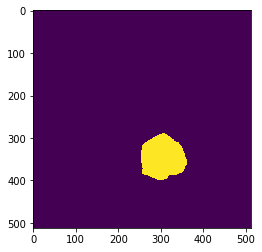

In [10]:
# mask.resampleImageFilter.Update()
data = itk.GetArrayFromImage(mask.GetOutput())
plt.imshow(data[7])

In [12]:
itk.ImageToVTKImageFilter.GetTypes()

<itkTemplate itk::ImageToVTKImageFilter>
Options:
  [<class 'itkImagePython.itkImageCVF22'>,]
  [<class 'itkImagePython.itkImageCVF23'>,]
  [<class 'itkImagePython.itkImageCVF32'>,]
  [<class 'itkImagePython.itkImageCVF33'>,]
  [<class 'itkImagePython.itkImageCVF42'>,]
  [<class 'itkImagePython.itkImageCVF43'>,]
  [<class 'itkImagePython.itkImageF2'>,]
  [<class 'itkImagePython.itkImageF3'>,]
  [<class 'itkImagePython.itkImageRGBAUC2'>,]
  [<class 'itkImagePython.itkImageRGBAUC3'>,]
  [<class 'itkImagePython.itkImageRGBUC2'>,]
  [<class 'itkImagePython.itkImageRGBUC3'>,]
  [<class 'itkImagePython.itkImageSS2'>,]
  [<class 'itkImagePython.itkImageSS3'>,]
  [<class 'itkImagePython.itkImageUC2'>,]
  [<class 'itkImagePython.itkImageUC3'>,]
  [<class 'itkImagePython.itkImageUL2'>,]
  [<class 'itkImagePython.itkImageUL3'>,]
  [<class 'itkImagePython.itkImageVF22'>,]
  [<class 'itkImagePython.itkImageVF23'>,]
  [<class 'itkImagePython.itkImageVF32'>,]
  [<class 'itkImagePython.itkImageVF33'>,

In [15]:
labelMapToLabelImageFilter = itk.LabelMapToLabelImageFilter[LMLOUL3, IUC3].New()

In [16]:
itk.LabelMapToLabelImageFilter.GetTypes()

<itkTemplate itk::LabelMapToLabelImageFilter>
Options:
  [<class 'ITKLabelMapBasePython.itkLabelMap2'>, <class 'itkImagePython.itkImageUC2'>]
  [<class 'ITKLabelMapBasePython.itkLabelMap3'>, <class 'itkImagePython.itkImageUC3'>]


In [17]:
itk.LabelMapToRGBImageFilter.GetTypes()

<itkTemplate itk::LabelMapToRGBImageFilter>
Options:
  [<class 'ITKLabelMapBasePython.itkLabelMap2'>, <class 'itkImagePython.itkImageRGBUC2'>]
  [<class 'ITKLabelMapBasePython.itkLabelMap3'>, <class 'itkImagePython.itkImageRGBUC3'>]
